# FIT5221 Week 9 - Tutorial

**Objective of today’s lab**
- Semantic segmentation

In [1]:
## import libraries
from typing import List
import tensorflow as tf
import tensorflow_datasets as tfds  # To download the dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow.python.eager.context import PhysicalDevice

print("TensorFlow version:", tf.__version__)
# setting the growth GPU memory occupying and print devices
try:
    devices: List[PhysicalDevice] = tf.config.list_physical_devices('GPU')
    for device in devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("Use devices:", list(map(lambda d: d.name, devices)))
except IndexError:
    print("Use CPU")

TensorFlow version: 2.16.1
Use devices: []


#Practice with Conv2DTranspose

Given a input size of (2x2) and filter size of (3x3), stride s and padding p, calculate the output of the Conv2DTranspose layer.
For example, input  
$x=\left[\begin{array}{ccc}
0 & 1\\
2 & 3
\end{array}\right]$
$kernel =\left[\begin{array}{ccc}
0 & 1 & 2\\
3 & 4 & 5\\
6 & 7 & 8
\end{array}\right]$



In [ ]:
import numpy as np
input = np.arange(4).reshape(1,2,2,1).astype(float)

In [ ]:
# stride=1, padding=0
convTranspose = tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='valid', use_bias=False)
convTranspose(input)
weight = np.arange(3*3*1).reshape(1,3,3,1,1).astype(float)
convTranspose.set_weights(weight)
out_conv = convTranspose(input)
print("Output shape", out_conv.shape)
print(out_conv.numpy().reshape(4,4))
print(out_conv.numpy())

Output shape (1, 4, 4, 1)
[[ 0.  0.  1.  2.]
 [ 0.  5. 11. 11.]
 [ 6. 23. 29. 23.]
 [12. 32. 37. 24.]]
[[[[ 0.]
   [ 0.]
   [ 1.]
   [ 2.]]

  [[ 0.]
   [ 5.]
   [11.]
   [11.]]

  [[ 6.]
   [23.]
   [29.]
   [23.]]

  [[12.]
   [32.]
   [37.]
   [24.]]]]


In [ ]:
# stride=1, padding=1
convTranspose = tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same', use_bias=False)
convTranspose(input)
weight = np.arange(3*3*1).reshape(1,3,3,1,1).astype(float)
convTranspose.set_weights(weight)
out_conv = convTranspose(input)
print("Output shape", out_conv.shape)
print(out_conv.numpy().reshape(2,2))

Output shape (1, 2, 2, 1)
[[ 5. 11.]
 [23. 29.]]


In [ ]:
# stride=2, padding=0
convTranspose = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='valid', use_bias=False)
convTranspose(input)
weight = np.arange(3*3*1).reshape(1,3,3,1,1).astype(float)
convTranspose.set_weights(weight)
out_conv = convTranspose(input)
print("Output shape", out_conv.shape)
# print(out_conv.numpy())
print(out_conv.numpy().reshape(5,5))

Output shape (1, 5, 5, 1)
[[ 0.  0.  0.  1.  2.]
 [ 0.  0.  3.  4.  5.]
 [ 0.  2. 10. 10. 14.]
 [ 6.  8. 19. 12. 15.]
 [12. 14. 34. 21. 24.]]


In [ ]:
# stride=2, padding=1
convTranspose = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', use_bias=False)
convTranspose(input)
weight = np.arange(3*3*1).reshape(1,3,3,1,1).astype(float)
convTranspose.set_weights(weight)
out_conv = convTranspose(input)
print("Output shape", out_conv.shape)
# print(out_conv.numpy())
print(out_conv.numpy().reshape(4,4))

Output shape (1, 4, 4, 1)
[[ 0.  0.  0.  1.]
 [ 0.  0.  3.  4.]
 [ 0.  2. 10. 10.]
 [ 6.  8. 19. 12.]]


# What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to **output a pixel-wise mask of the image**. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

## Prepare Dataset

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [6]:
# from tensorflow.python.keras.layers.preprocessing.image_preprocessing import ResizeMethod
# from tensorflow.keras.preprocessing import ResizeMethod

# download from https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


# preprocessing
# In addition, the image color values are normalized to the [0, 1] range.
# Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}.
# For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


# read image from file
def load_image(datapoint):
    print(datapoint.keys())
    input_image = tf.image.resize(datapoint['image'], (224, 224))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

# hyperparameters for dataset
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])


In [25]:
dataset['train']

<_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [2]:
from tensorflow.keras.layers import Layer, Resizing
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomCrop

class DataAugmentation(Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = RandomFlip(mode="horizontal", seed=seed)
        self.crop_img = RandomCrop(224, 224, seed=seed+23)
        self.crop_label = RandomCrop(224, 224, seed=seed+23)

    def call(self, inputs, *args):
        labels = args[0]
        print(inputs.shape)
        # print(len(args))
        inputs = self.augment_inputs(inputs)
        inputs = self.crop_img(inputs)
        labels = self.augment_labels(labels)
        labels = self.crop_label(labels) # mask

        print(inputs.shape)
        # print(len(args))
        return inputs, labels


class DataAugmentation_test(Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.resize = Resizing(224,224)

    def call(self, inputs, *args):
        labels = args[0]
        print(inputs.shape)
        # print(len(args))
        inputs = self.resize(inputs)
        labels = self.resize(labels)

        print(inputs.shape)
        # print(len(args))
        return inputs, labels


# add label weights for each image
def add_sample_weights(image, label):
    unique_with_counts = tf.unique_with_counts(tf.reshape(label, shape=[-1]))
    class_weights = 1 / tf.concat([unique_with_counts.count[unique_with_counts.y == 0],
                                   unique_with_counts.count[unique_with_counts.y == 1],
                                   unique_with_counts.count[unique_with_counts.y == 2]], axis=0)

    class_weights = class_weights / tf.reduce_sum(class_weights)  # [3,]

    # Create an image of `sample_weights` by using the label at each pixel as an
    # index into the `class weights` .
    weight = tf.gather(class_weights, indices=tf.cast(label, tf.int32))  # [128, 128, 1]

    return image, label, weight # change the pixel in the label to the other range for visualization


train_batches = (
    train_images
        .cache() # save data to disk
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(DataAugmentation())
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .map(add_sample_weights, num_parallel_calls=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE).map(DataAugmentation_test()).map(add_sample_weights, num_parallel_calls=tf.data.AUTOTUNE)
# test_batches = test_images.batch(BATCH_SIZE).map(add_sample_weights, num_parallel_calls=tf.data.AUTOTUNE)

ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'

In [ ]:
train_batches

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float64, name=None))>

In [17]:
test_batches

NameError: name 'test_batches' is not defined

In [ ]:
def display(display_list, title=('Input Image', 'True Mask', 'Predicted Mask')):
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def display_with_weights(display_list):
    return display(display_list, title=('Input Image', 'True Mask', 'Weights'))

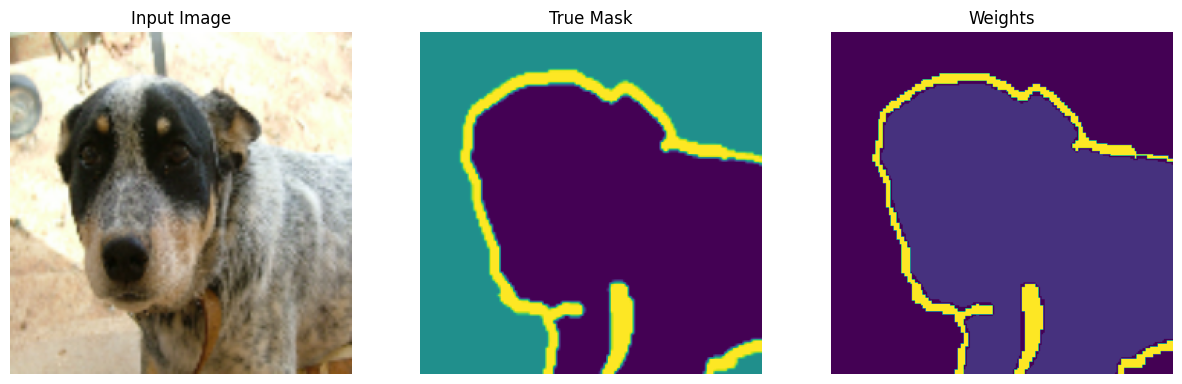

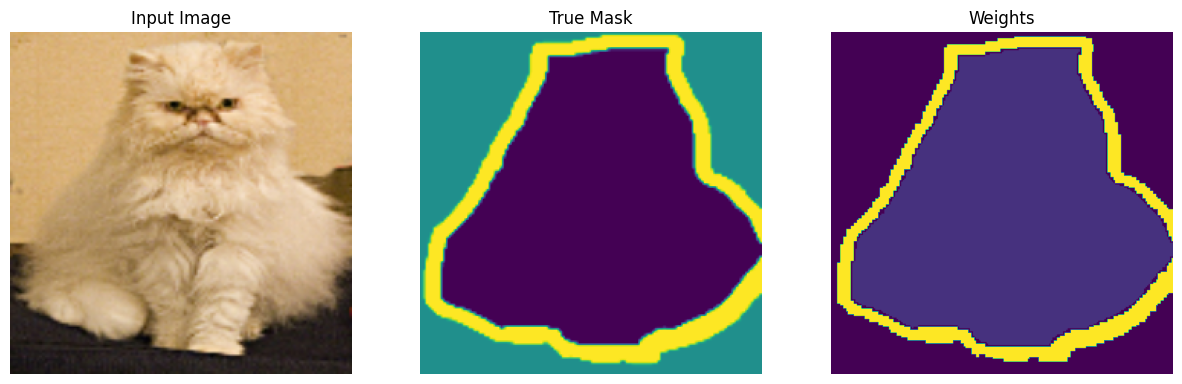

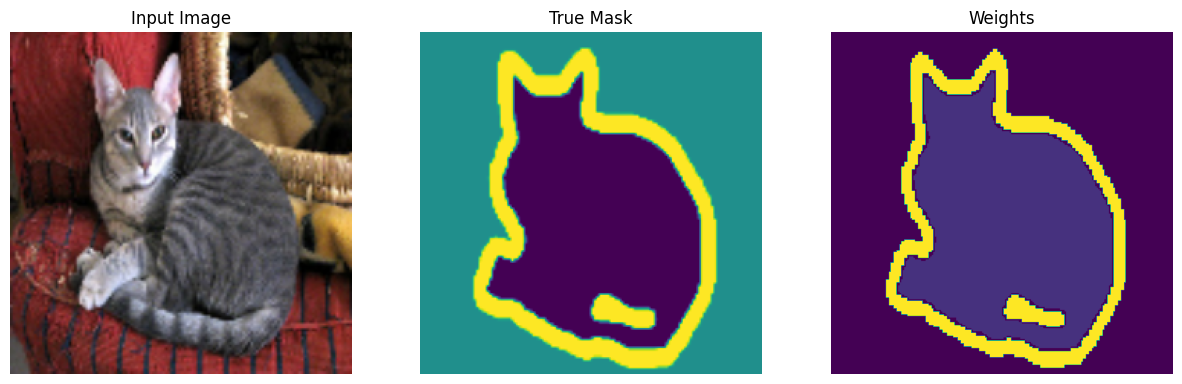

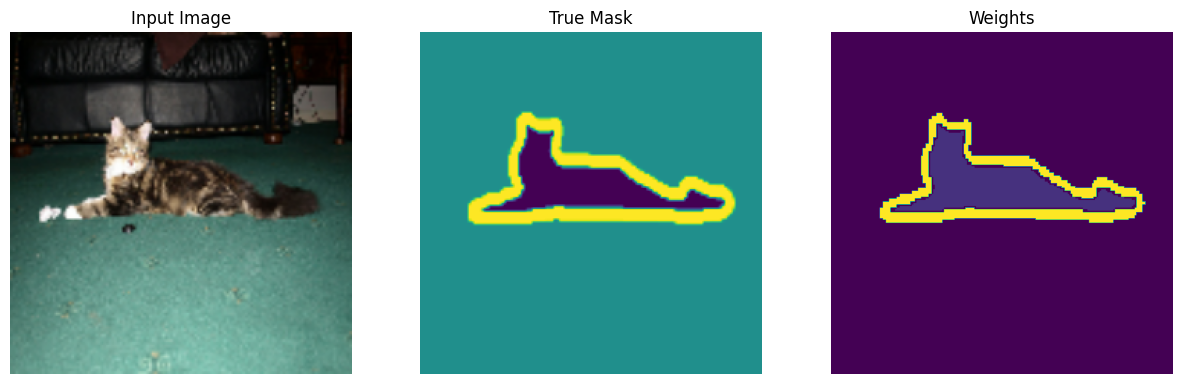

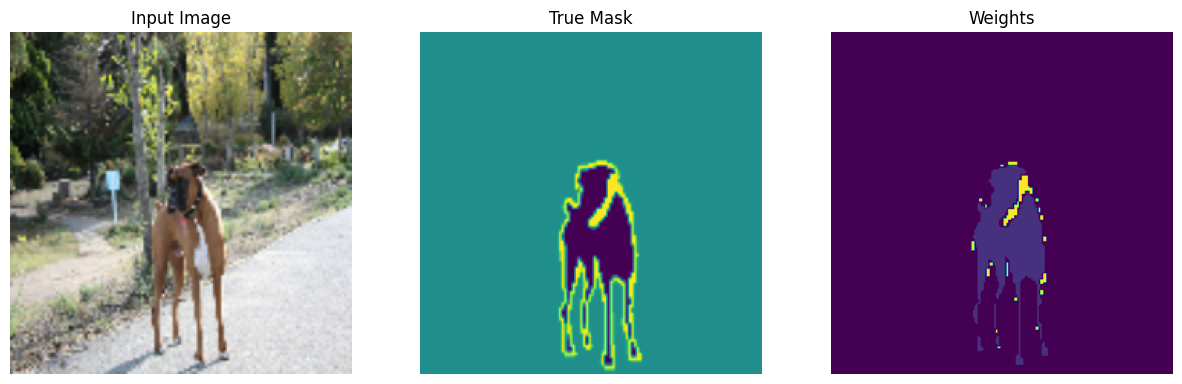

In [ ]:
n = 5
for images, masks, weights in train_batches.take(1):
  for i in range(min(n, len(images))):
    sample_image, sample_mask, sample_weights = images[i], masks[i], weights[i]
    display_with_weights([sample_image, sample_mask, sample_weights])

In [ ]:
sample_image.shape

TensorShape([224, 224, 3])

## Build model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py).

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=[224, 224, 3], include_top=False) #backbone

# Use the activations of these layers for downsample pathway
layer_names = [       #Input: 112x112        224x224
    'block_1_expand_relu',  # 64x64        # 112x112x96
    'block_3_expand_relu',  # 32x32        # 56x56x144
    'block_6_expand_relu',  # 16x16        # 28x28x192
    'block_9_depthwise_relu', # 8x8        # 14x14x384
    'block_16_project',  # 4x4             # 7x7x320
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False # keep the params in down_stack is the same as pretrained model

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
# !pip install -q git+https://github.com/tensorflow/examples.git
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23737, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (419/419), done.
remote: Total 23737 (delta 234), reused 561 (delta 194), pack-reused 23036
Receiving objects: 100% (23737/23737), 44.18 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (12883/12883), done.


We design the Decoder of Unet consisting multiple upsample blocks in Pix2Pix model. Each Upsample block consists:
- a Conv2DTranspose with `strides=2`, `padding='same'`
- a BatchNorm layer layer
- a RELU activation function

In [ ]:
from examples.tensorflow_examples.models.pix2pix import pix2pix  #  For pretrained model

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8x512.        7x7xc     -> 14x14x512      # block 1 of upsample
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16       14x14x512 -> 28x28x256      # block 2 of upsample
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32     28x28x256 -> 56x56x128      # block 3 of upsample
    pix2pix.upsample(64, 3),  # 32x32 -> 64x64 #    56x56x128 -> 112x112x64     # block 4 of upsample
]

In [ ]:
from tensorflow.keras.layers import Concatenate, Conv2DTranspose


def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model    
    skips = down_stack(inputs) # Skips is downsample pathway
    x = skips[-1]
    skips = reversed(skips[:-1]) # the last intermediate 7x7xc5

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)       # up: upsampling block -> x: 14x14x512
        concat = Concatenate()
        print(x.shape)
        print(skip.shape)
        x = concat([x, skip])
    #x: 112x112
    # This is the last layer of the model
    last = Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128      112x112 -> 224x224xC , C=3

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary() #unet model

(None, 14, 14, 512)
(None, 14, 14, 384)
(None, 28, 28, 256)
(None, 28, 28, 192)
(None, 56, 56, 128)
(None, 56, 56, 144)
(None, 112, 112, 64)
(None, 112, 112, 96)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 112, 112, 96),       1841984   ['input_3[0][0]']             
                              (None, 56, 56, 144),                                                
                              (None, 28, 28, 192),                                                
                              (None, 14, 14, 384),                                                
                             

In [1]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

NameError: name 'model' is not defined

## Train the model

2/2 [==============================] - 9s 3s/step


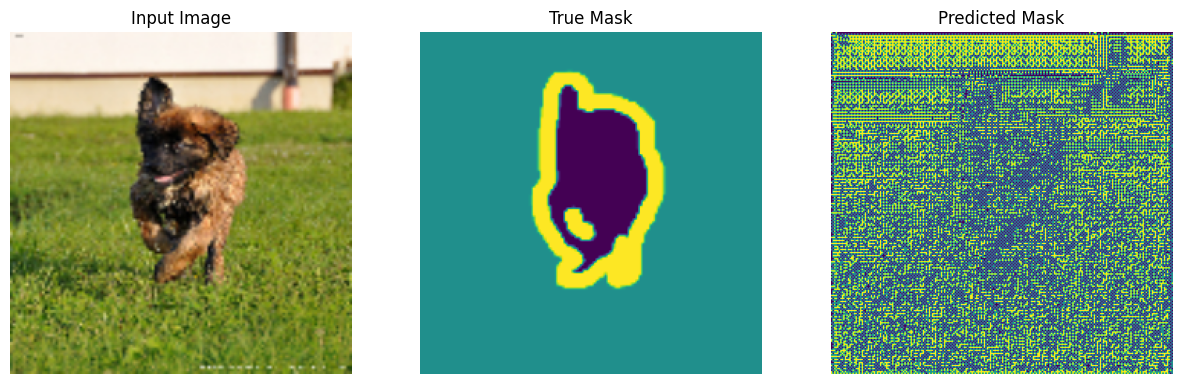

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask, _ in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])


show_predictions(test_batches)

In [ ]:
from tensorflow.keras.callbacks import Callback


class DisplayCallback(Callback):

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(test_batches, 3)
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))


EPOCHS = 100
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

In [ ]:
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_batches,
                          validation_steps=VALIDATION_STEPS,
                          callbacks=[DisplayCallback()])

Epoch 1/100
19/57 [=========>....................] - ETA: 9:56 - loss: 0.1390 - accuracy: 0.6803 

In [ ]:
model.save_weights("Unet-Pix2Pix.h5")

In [ ]:
model.evaluate(test_batches)

58/58 [==============================] - 14s 239ms/step - loss: 0.1988 - accuracy: 0.8873


[0.1988237202167511, 0.8873054385185242]

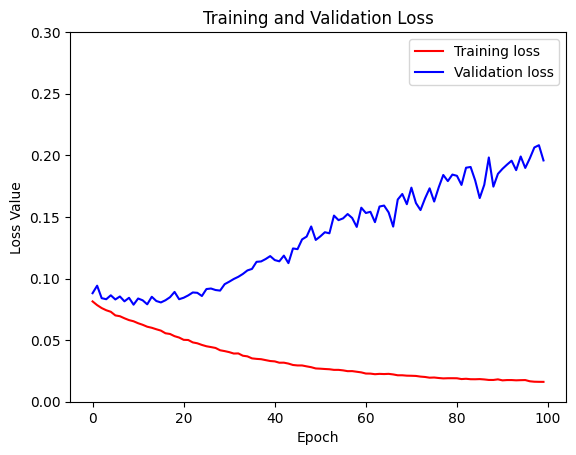

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

## Prediction Examples

2/2 [==============================] - 0s 73ms/step


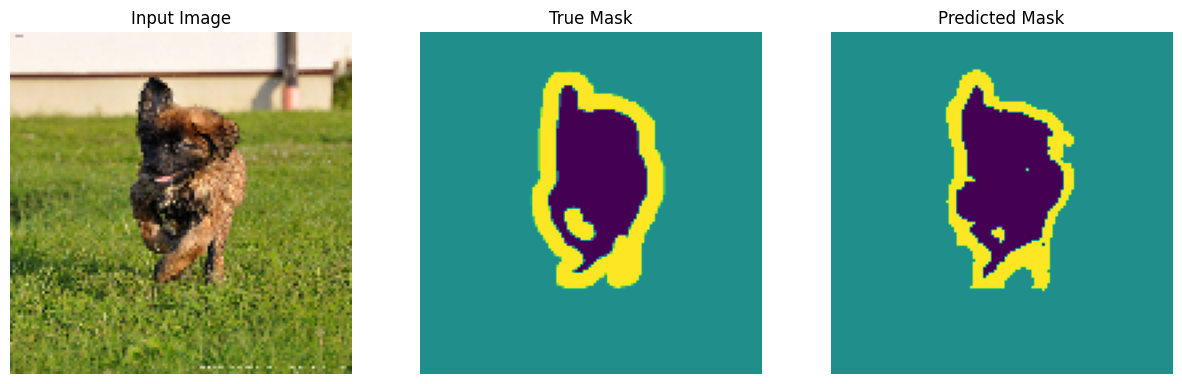

2/2 [==============================] - 0s 47ms/step


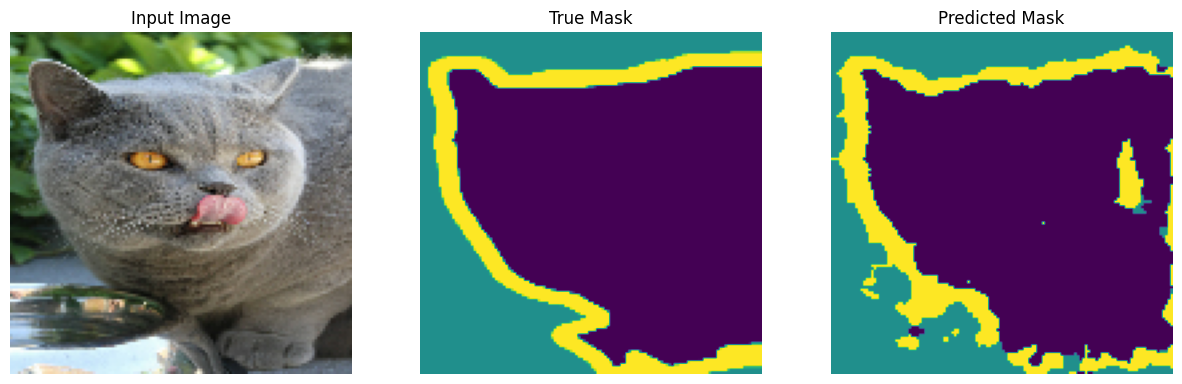

2/2 [==============================] - 0s 41ms/step


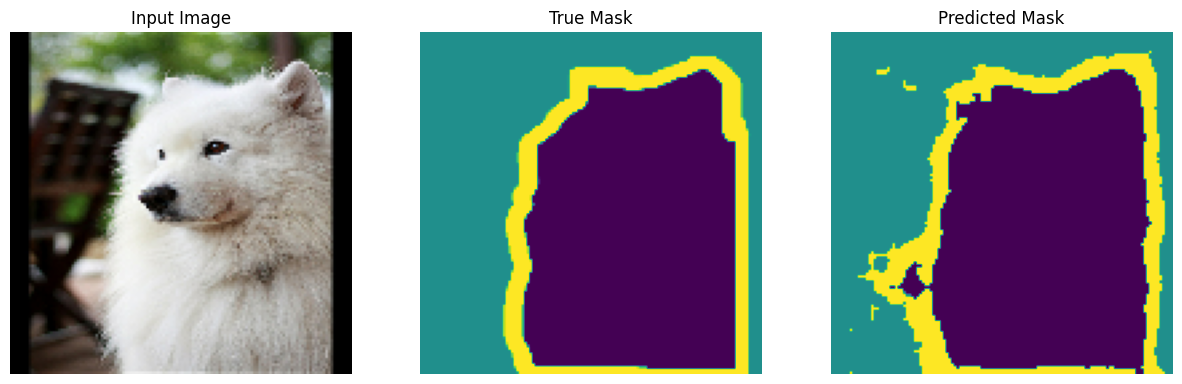

In [ ]:
show_predictions(test_batches, 3)

## Reference

Image segmentation  |  TensorFlow Core. (2022). Retrieved 4 May 2022, from https://www.tensorflow.org/tutorials/images/segmentation